# Import Packages

In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create DataFrame with Images and Labels

In [2]:
data_path = "/kaggle/input/de-fungi/de_fungi" 

images = []
labels = []

for subfolder in os.listdir(data_path):
    
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
data = pd.DataFrame({'image': images, 'label': labels})

In [3]:
data.head()

,image,label
0,/kaggle/input/de-fungi/de_fungi/H3/H3_5a_17.jpg,H3
1,/kaggle/input/de-fungi/de_fungi/H3/H3_5b_9.jpg,H3
2,/kaggle/input/de-fungi/de_fungi/H3/H3_11a_42.jpg,H3
3,/kaggle/input/de-fungi/de_fungi/H3/H3_3c_16.jpg,H3
4,/kaggle/input/de-fungi/de_fungi/H3/H3_29a_3.jpg,H3


In [4]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (100, 100)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator()  


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 2956 validated image filenames belonging to 5 classes.
Found 369 validated image filenames belonging to 5 classes.
Found 370 validated image filenames belonging to 5 classes.


# Callback 

In [6]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        
        if accuracy:
            print(f"Epoch {epoch + 1}: Training accuracy is {accuracy:.4f}")
        if val_accuracy:
            print(f"Epoch {epoch + 1}: Validation accuracy is {val_accuracy:.4f}")
        
        if (accuracy and accuracy > 0.99) or (val_accuracy and val_accuracy > 0.99):
            print("\nReached 99% accuracy in training or validation, so cancelling training!")
            self.model.stop_training = True

# Custom CNN Model

In [7]:
from tensorflow.keras.layers import BatchNormalization


n_classes = 5
input_shape = (100, 100, 3)

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))



model.add(Flatten())

model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,133 (3.82 MB)

 Trainable params: 998,661 (3.81 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler


def lr_scheduler(epoch, lr):
    new_lr = lr * tf.math.exp(-0.1)
    return float(new_lr.numpy())

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.0001
)

callbacks = [
    myCallback(),
    LearningRateScheduler(lr_scheduler),
    reduce_lr
]

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=10,
    batch_size=32,
    verbose=2,
    validation_data=valid_gen,
    callbacks=callbacks
)

Epoch 1/10


I0000 00:00:1743504999.125805      95 service.cc:145] XLA service 0x7cc610001f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743504999.125862      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1743505005.454884      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1: Training accuracy is 0.5338
Epoch 1: Validation accuracy is 0.2412
93/93 - 35s - 379ms/step - accuracy: 0.5338 - loss: 2.5436 - val_accuracy: 0.2412 - val_loss: 3.0800 - learning_rate: 9.0484e-04
Epoch 2/10
Epoch 2: Training accuracy is 0.6191
Epoch 2: Validation accuracy is 0.3198
93/93 - 13s - 137ms/step - accuracy: 0.6191 - loss: 2.2491 - val_accuracy: 0.3198 - val_loss: 2.8622 - learning_rate: 8.1873e-04
Epoch 3/10
Epoch 3: Training accuracy is 0.6499
Epoch 3: Validation accuracy is 0.5420
93/93 - 13s - 138ms/step - accuracy: 0.6499 - loss: 2.0998 - val_accuracy: 0.5420 - val_loss: 2.2787 - learning_rate: 7.4082e-04
Epoch 4/10
Epoch 4: Training accuracy is 0.6675
Epoch 4: Validation accuracy is 0.7073
93/93 - 13s - 135ms/step - accuracy: 0.6675 - loss: 2.0121 - val_accuracy: 0.7073 - val_loss: 1.9548 - learning_rate: 6.7032e-04
Epoch 5/10
Epoch 5: Training accuracy is 0.6911
Epoch 5: Validation accuracy is 0.7073
93/93 - 12s - 133ms/step - accuracy: 0.6911 - loss: 1.9245 -

# Loss and Accuracy Plot

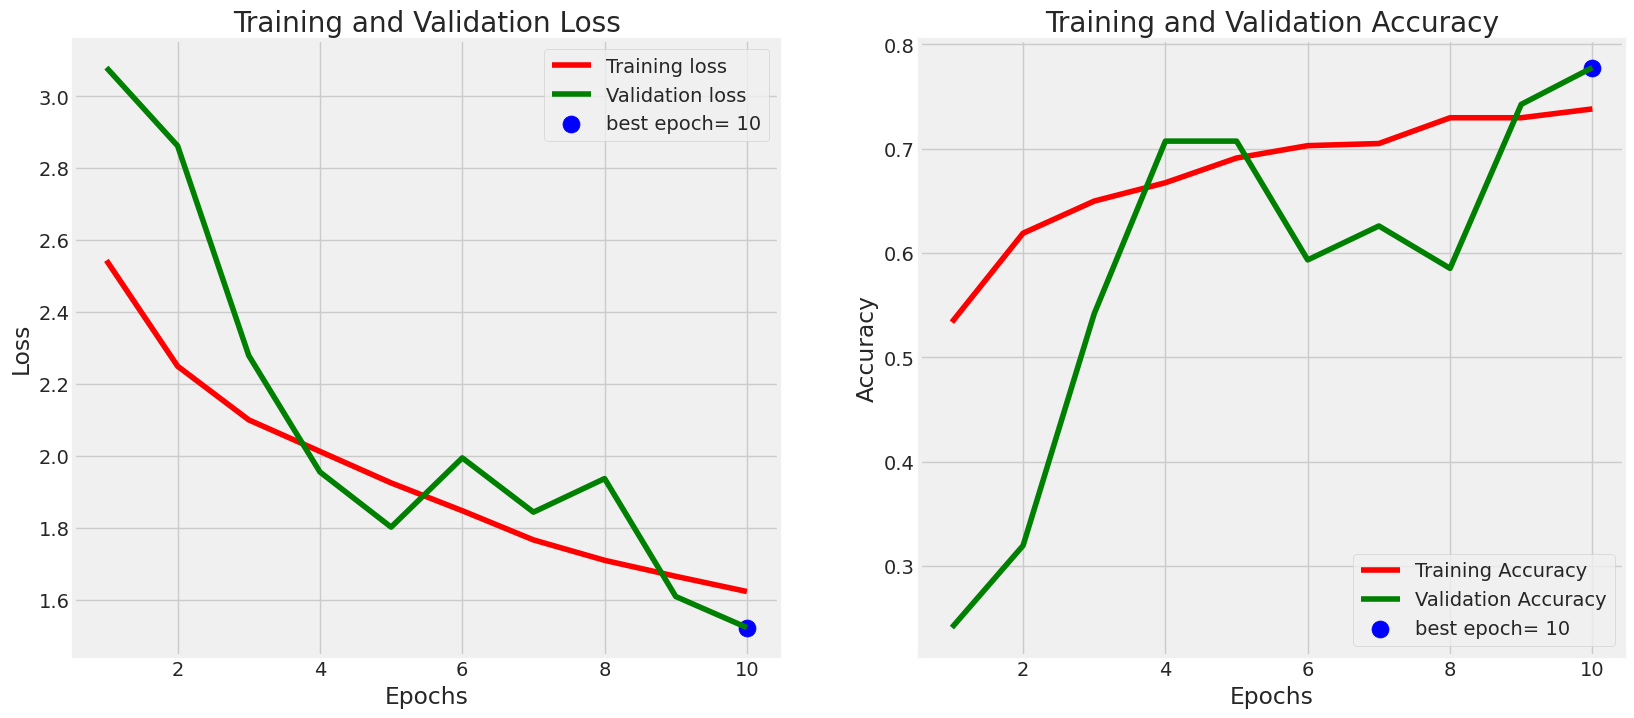

In [9]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout

plt.savefig('training_validation_plots.png')
plt.show()

# Save Model

In [10]:
model.save('model_1.h5')


# Accuracy Score

In [11]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.8037 - loss: 1.4437
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8056 - loss: 1.4705
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8442 - loss: 1.4717
Train Loss:  1.4545189142227173
Train Accuracy:  0.7875000238418579
--------------------
Valid Loss:  1.5223459005355835
Valid Accuracy:  0.7749999761581421
--------------------
Test Loss:  1.4681990146636963
Test Accuracy:  0.84375


# Classification Report

In [12]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


In [13]:
import numpy as np

true_labels = np.array(test_gen.classes)

print("Shape of true labels:", true_labels.shape)
print("Shape of predicted labels:", y_pred.shape)


Shape of true labels: (370,)
Shape of predicted labels: (370,)


In [14]:
from sklearn.metrics import classification_report
classes = ['H1', 'H2', 'H3', 'H4', 'H5']

print(classification_report(true_labels, y_pred, target_names=classes))


              precision    recall  f1-score   support

          H1       0.78      0.69      0.73        74
          H2       0.67      0.62      0.64        74
          H3       0.71      0.85      0.77        74
          H4       0.89      0.84      0.86        74
          H5       0.90      0.93      0.91        74

    accuracy                           0.79       370
   macro avg       0.79      0.79      0.79       370
weighted avg       0.79      0.79      0.79       370



# Image Visualization

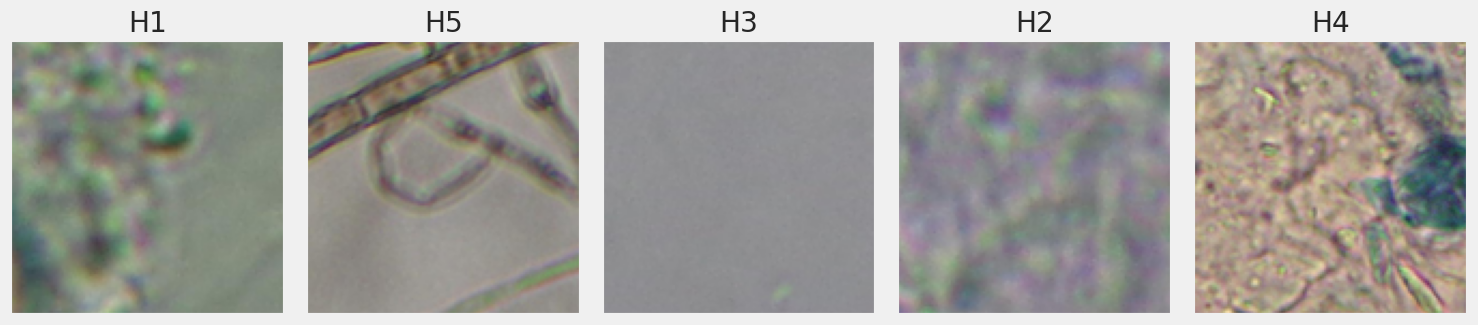

In [15]:
import matplotlib.pyplot as plt
from PIL import Image

class_samples = []

for label in test_df['label'].unique():
    sample = test_df[test_df['label'] == label].iloc[0]  
    class_samples.append((sample['image'], sample['label']))

target_size = (128, 128)  

# Plot the images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, (filepath, label) in zip(axes, class_samples):
    img = Image.open(filepath)
    img_resized = img.resize(target_size)
    ax.imshow(img_resized)
    ax.set_title(label)

plt.tight_layout()
plt.savefig('Display_images.jpg', dpi=1200)
plt.show()

# Confusion Matrix

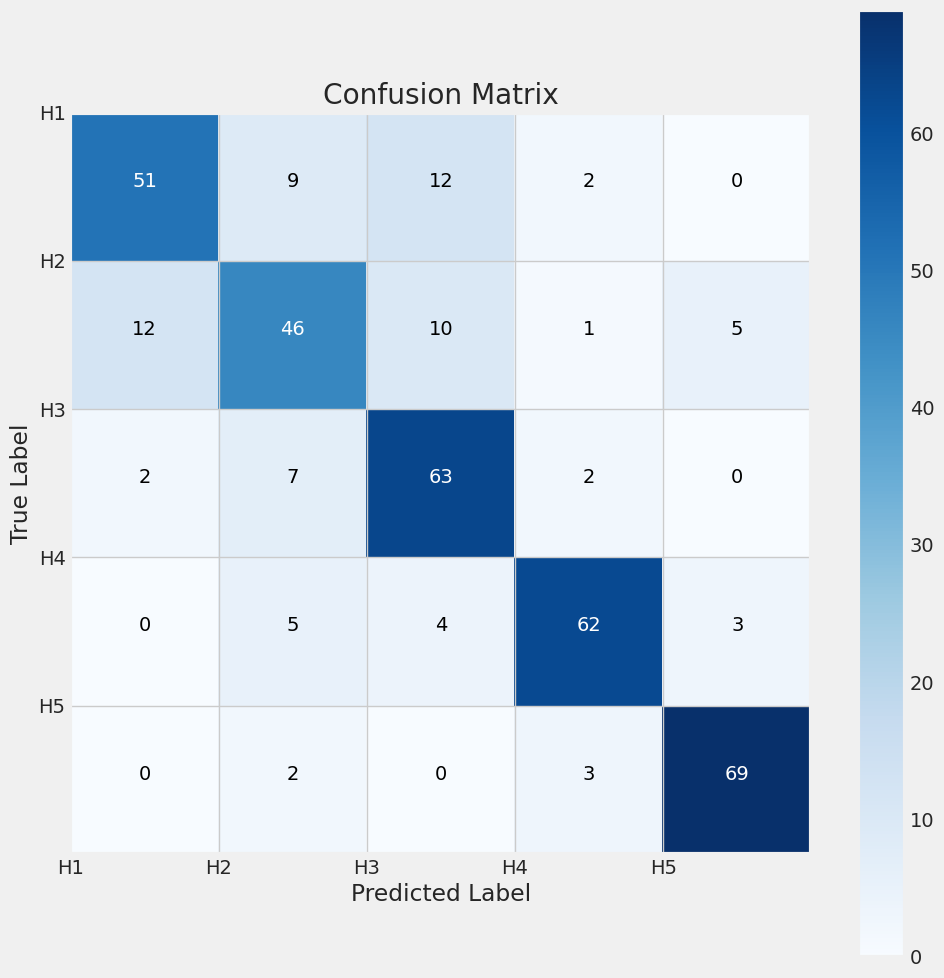

In [16]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)  
plt.yticks(tick_marks - 0.5, classes) 


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig('confusion_matrix.png')
plt.show()

# ROC Curve

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


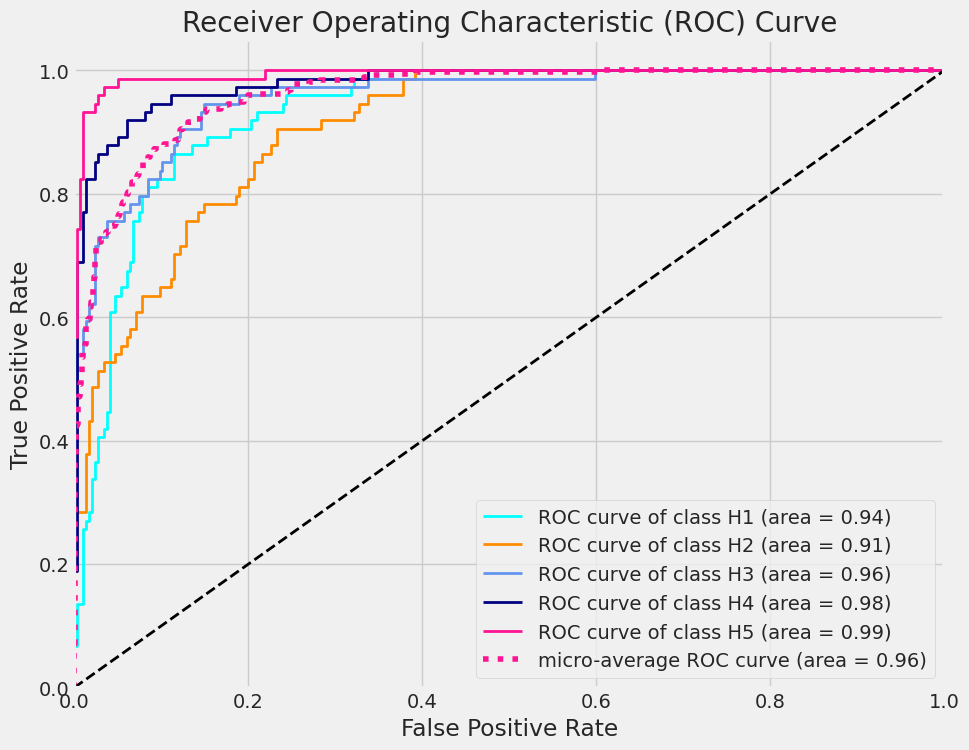

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools


n_classes = len(classes)

y_true = label_binarize(test_gen.classes, classes=range(n_classes))
y_pred_probs = model.predict(test_gen)  

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.savefig('roc_curve1.png',  dpi=1200) 
plt.show()

# AUC Score

In [18]:
from sklearn.metrics import roc_auc_score

auc_scores = {}
for i in range(n_classes):
    auc_scores[classes[i]] = roc_auc_score(y_true[:, i], y_pred_probs[:, i])

for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(y_true, y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(y_true, y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")

AUC for class H1: 0.94
AUC for class H2: 0.91
AUC for class H3: 0.96
AUC for class H4: 0.98
AUC for class H5: 0.99
Micro-average AUC: 0.96
Macro-average AUC: 0.96


# Precision Recall Curve

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


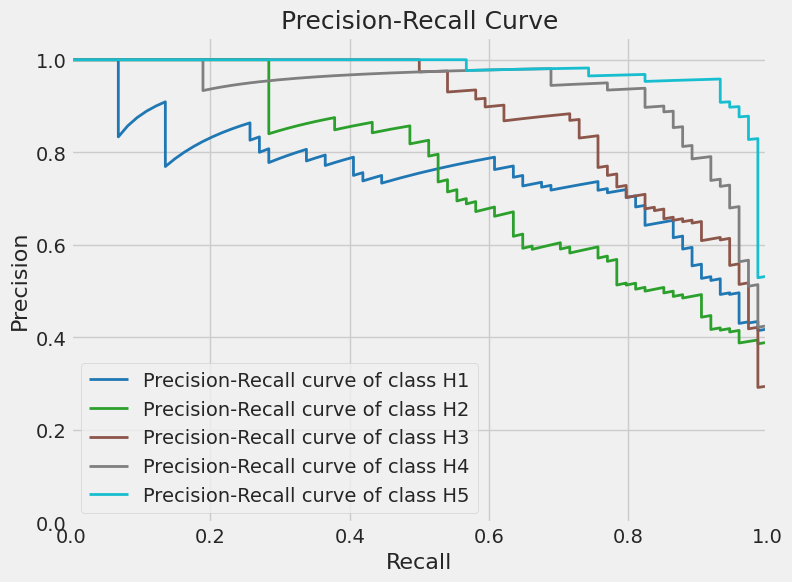

AUC for class H1: 0.94
AUC for class H2: 0.91
AUC for class H3: 0.96
AUC for class H4: 0.98
AUC for class H5: 0.99
Micro-average AUC: 0.96
Macro-average AUC: 0.96


In [19]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

n_classes = len(classes)  

y_true = label_binarize(test_gen.classes, classes=range(n_classes))

y_pred_probs = model.predict(test_gen)

colors = plt.cm.get_cmap('tab10', n_classes).colors

precision = dict()
recall = dict()

plt.figure(figsize=(8, 6))

for i, color in zip(range(n_classes), colors):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall curve of class {classes[i]}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision-Recall Curve', fontsize=18)
plt.legend(loc="lower left", fontsize=14)
plt.savefig('PR_Curve.png', dpi=300)
plt.show()

auc_scores = {classes[i]: roc_auc_score(y_true[:, i], y_pred_probs[:, i]) for i in range(n_classes)}
for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(y_true, y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(y_true, y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")

# EfficientNetV2S 

In [20]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(5, activation='softmax')(x)  # 5 classes

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [21]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report
import numpy as np


base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(5, activation='softmax')(x) 
model1 = Model(inputs=base_model.input, outputs=output)

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

history = model1.fit(
    train_gen,
    epochs=10,
    validation_data=valid_gen,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

val_loss, val_accuracy = model1.evaluate(valid_gen)
print(f"Validation Accuracy: {val_accuracy:.4f}")

val_predictions = model1.predict(valid_gen)
val_predictions_classes = np.argmax(val_predictions, axis=1)

val_true_labels = valid_gen.classes

print("Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

Epoch 1/10


I0000 00:00:1743505370.762219      93 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_15', 104 bytes spill stores, 132 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_22', 440 bytes spill stores, 476 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 12 bytes spill stores, 12 bytes spill loads



19/93 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.2710 - loss: 1.6252

I0000 00:00:1743505497.514463      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads



93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4518 - loss: 1.3227
Epoch 1: val_loss improved from inf to 0.69024, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.4532 - loss: 1.3200 - val_accuracy: 0.7344 - val_loss: 0.6902 - learning_rate: 1.0000e-04
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7509 - loss: 0.6473
Epoch 2: val_loss improved from 0.69024 to 0.52692, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.7509 - loss: 0.6471 - val_accuracy: 0.7940 - val_loss: 0.5269 - learning_rate: 1.0000e-04
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8199 - loss: 0.5018
Epoch 3: val_loss improved from 0.52692 to 0.39862, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - accuracy: 0.8199 - loss: 0.5017 - val_accuracy: 0.8482 - val_loss: 0.3986 - learning_rate: 1.0000e-04
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.858

In [22]:
model1.save('model_EfficientNetV2S.h5')


In [23]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model1.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model1.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model1.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9752 - loss: 0.0680
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9385 - loss: 0.1789
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9276 - loss: 0.2453
Train Loss:  0.07389353960752487
Train Accuracy:  0.9750000238418579
--------------------
Valid Loss:  0.18057195842266083
Valid Accuracy:  0.9312499761581421
--------------------
Test Loss:  0.24806444346904755
Test Accuracy:  0.9312499761581421


In [24]:
val_loss, val_accuracy = model1.evaluate(valid_gen)

print(f"Validation Accuracy: {val_accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9379 - loss: 0.1787
Validation Accuracy: 0.9377


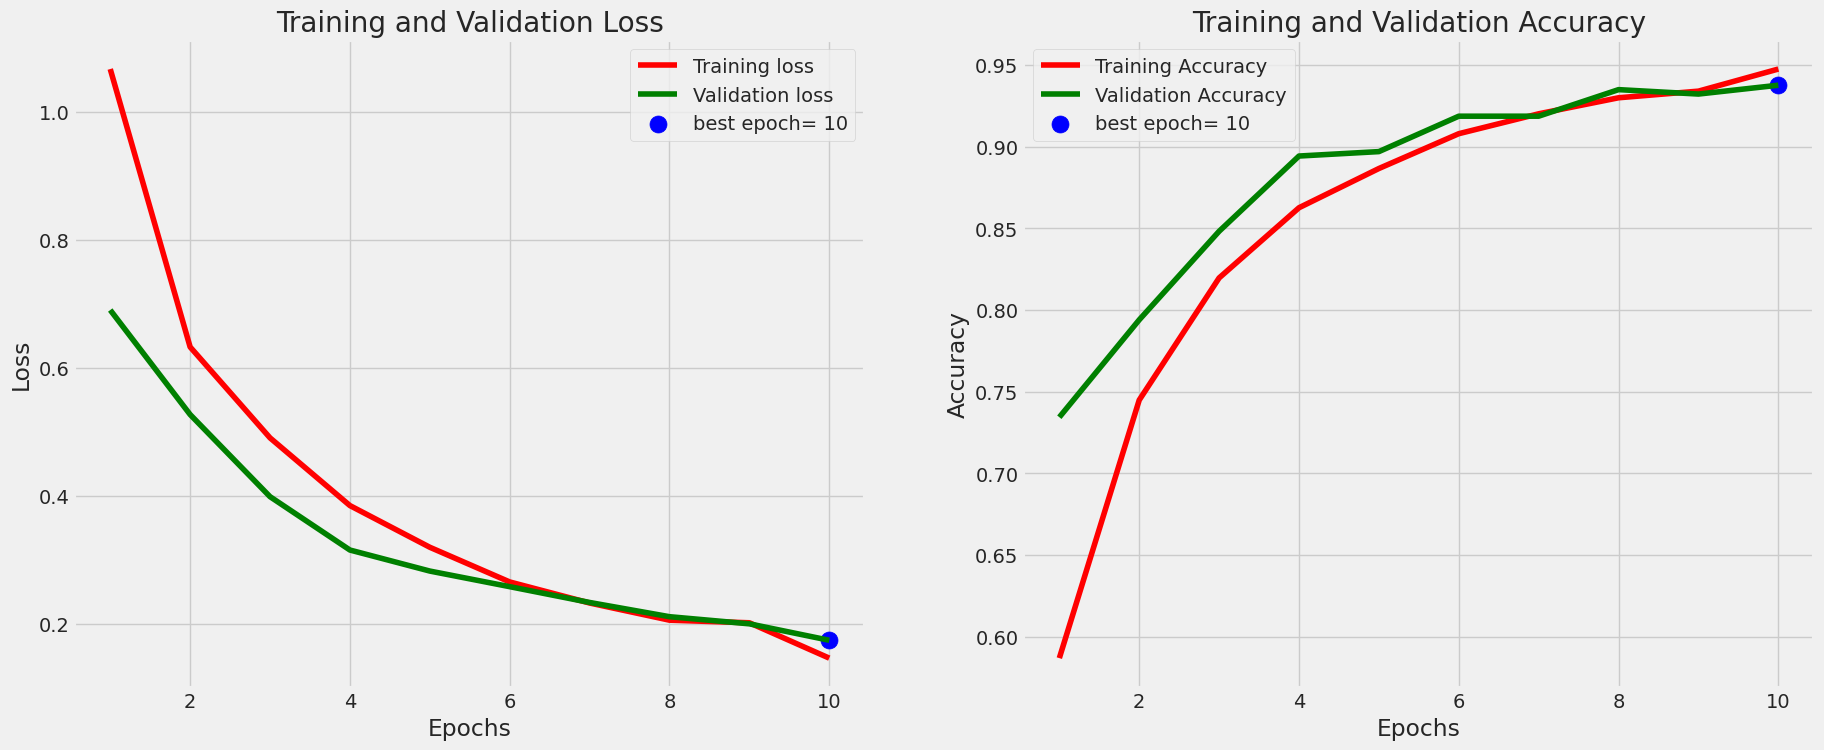

In [25]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout

plt.savefig('training_validation_plots.png')
plt.show()

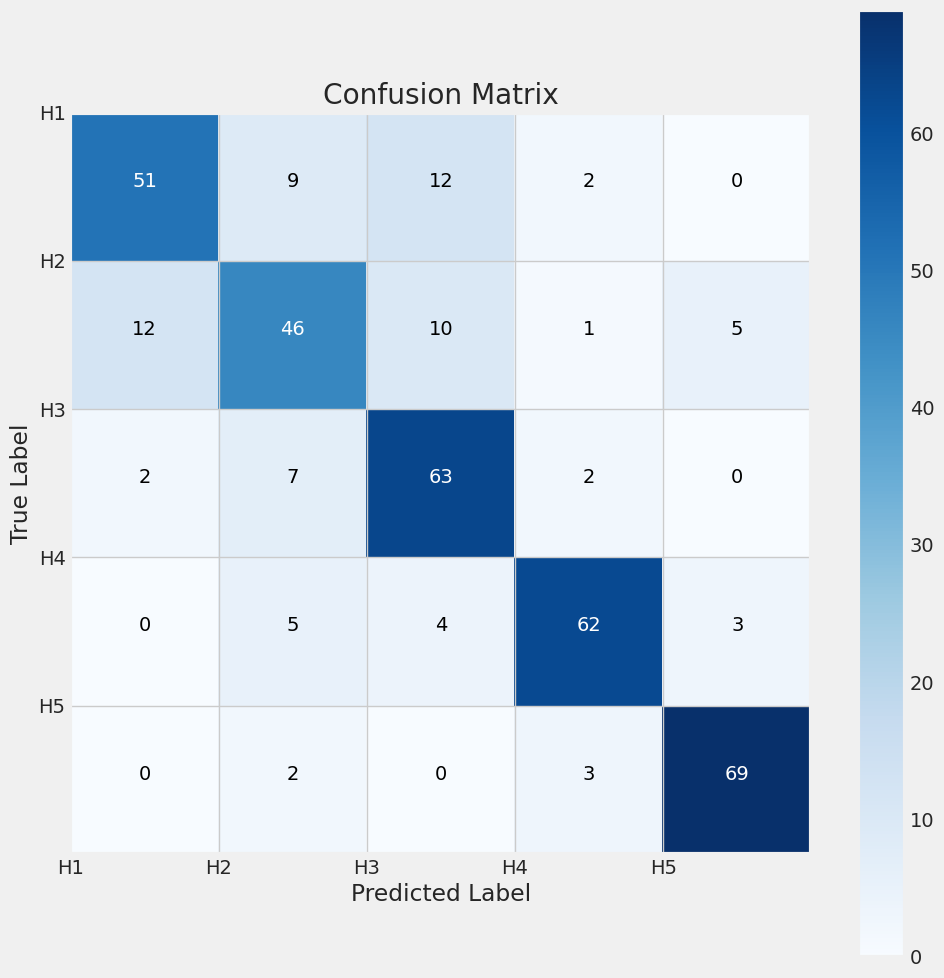

In [26]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)  
plt.yticks(tick_marks - 0.5, classes) 


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig('confusion_matrix.png')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 445ms/step


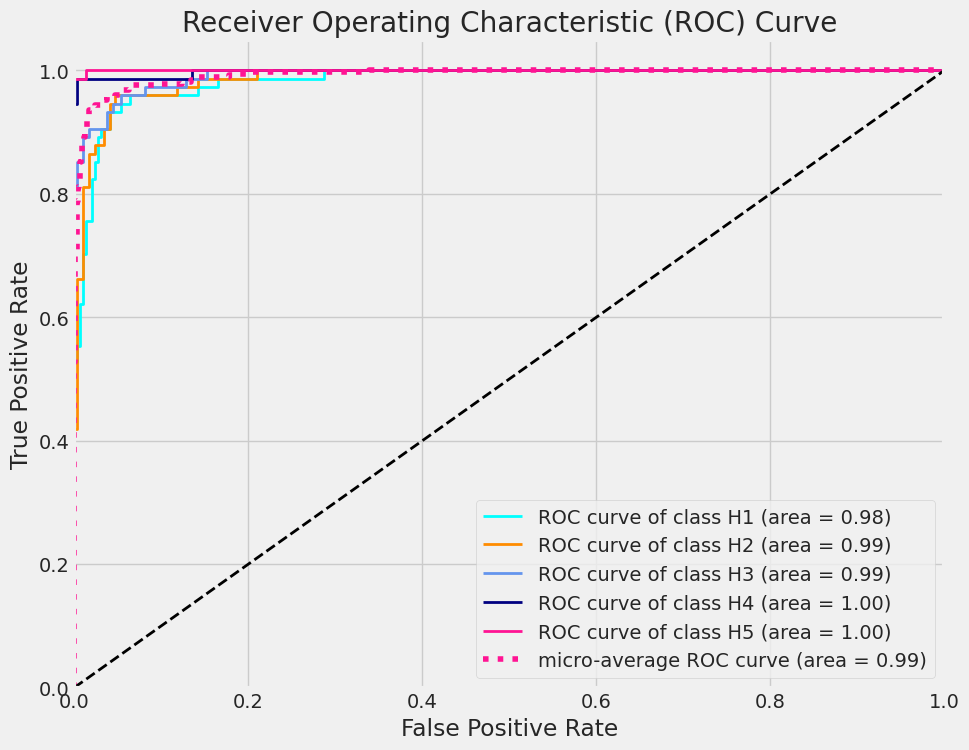

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools


n_classes = len(classes)

y_true = label_binarize(test_gen.classes, classes=range(n_classes))
y_pred_probs = model1.predict(test_gen)  

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.savefig('roc_curve1.png',  dpi=1200) 
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score

auc_scores = {}
for i in range(n_classes):
    auc_scores[classes[i]] = roc_auc_score(y_true[:, i], y_pred_probs[:, i])

for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(y_true, y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(y_true, y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")

AUC for class H1: 0.98
AUC for class H2: 0.99
AUC for class H3: 0.99
AUC for class H4: 1.00
AUC for class H5: 1.00
Micro-average AUC: 0.99
Macro-average AUC: 0.99


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


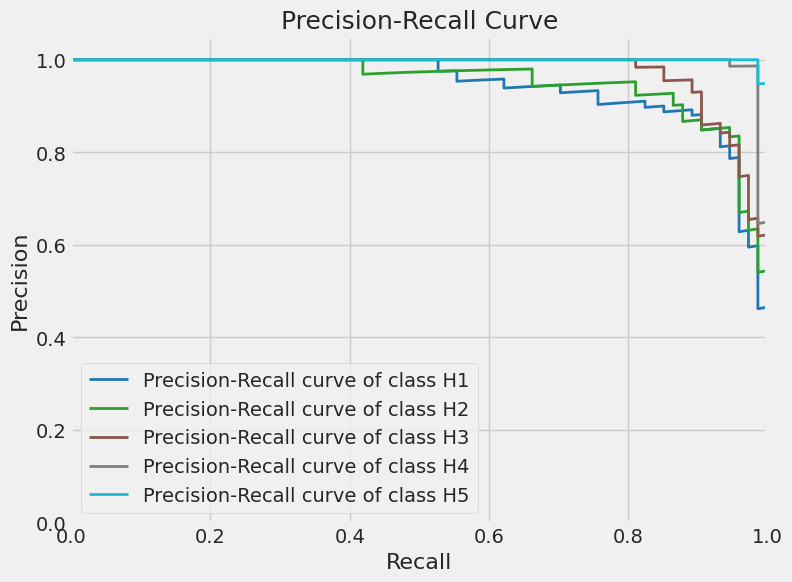

AUC for class H1: 0.98
AUC for class H2: 0.99
AUC for class H3: 0.99
AUC for class H4: 1.00
AUC for class H5: 1.00
Micro-average AUC: 0.99
Macro-average AUC: 0.99


In [29]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

n_classes = len(classes)  

y_true = label_binarize(test_gen.classes, classes=range(n_classes))

y_pred_probs = model1.predict(test_gen)

colors = plt.cm.get_cmap('tab10', n_classes).colors

precision = dict()
recall = dict()

plt.figure(figsize=(8, 6))

for i, color in zip(range(n_classes), colors):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall curve of class {classes[i]}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision-Recall Curve', fontsize=18)
plt.legend(loc="lower left", fontsize=14)
plt.savefig('PR_Curve.png', dpi=300)
plt.show()

auc_scores = {classes[i]: roc_auc_score(y_true[:, i], y_pred_probs[:, i]) for i in range(n_classes)}
for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(y_true, y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(y_true, y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")

# VGG16

In [30]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report
import numpy as np

base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

def build_vgg16_model():
    x = base_model_vgg16.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(5, activation='softmax')(x)  

    model2 = Model(inputs=base_model_vgg16.input, outputs=output)
    model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model2

def train_and_evaluate_vgg16(train_gen, valid_gen):
    print("Training VGG16...")
    
    model2 = build_vgg16_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('vgg16_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history2 = model2.fit(
        train_gen,
        epochs=5,  
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model2.evaluate(valid_gen)
    print(f"VGG16 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model2.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"VGG16 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_vgg16(train_gen, valid_gen)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training VGG16...
Epoch 1/5
 2/93 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.2266 - loss: 7.8177  

I0000 00:00:1743505726.189842      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 12 bytes spill loads



 6/93 ━━━━━━━━━━━━━━━━━━━━ 1:15 869ms/step - accuracy: 0.2370 - loss: 5.2546

I0000 00:00:1743505730.439458      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads



93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.4059 - loss: 1.8751
Epoch 1: val_loss improved from inf to 1.08114, saving model to vgg16_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.4068 - loss: 1.8692 - val_accuracy: 0.5745 - val_loss: 1.0811 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5939 - loss: 0.9791
Epoch 2: val_loss improved from 1.08114 to 1.04066, saving model to vgg16_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.5941 - loss: 0.9786 - val_accuracy: 0.6233 - val_loss: 1.0407 - learning_rate: 1.0000e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6837 - loss: 0.7848
Epoch 3: val_loss improved from 1.04066 to 0.62419, saving model to vgg16_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.6839 - loss: 0.7843 - val_accuracy: 0.7398 - val_loss: 0.6242 - learning_rate: 1.0000e-04
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/st

# ResNet50

In [31]:
from tensorflow.keras.applications import ResNet50

base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

def build_resnet50_model():
    x = base_model_resnet50.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(5, activation='softmax')(x)  

    model3 = Model(inputs=base_model_resnet50.input, outputs=output)
    model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model3

def train_and_evaluate_resnet50(train_gen, valid_gen):
    print("Training ResNet50...")
    
    model3 = build_resnet50_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('resnet50_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history3 = model3.fit(
        train_gen,
        epochs=5,  
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model3.evaluate(valid_gen)
    print(f"ResNet50 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"ResNet50 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_resnet50(train_gen, valid_gen)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training ResNet50...
Epoch 1/5
 1/93 ━━━━━━━━━━━━━━━━━━━━ 1:12:45 47s/step - accuracy: 0.2188 - loss: 2.1235

I0000 00:00:1743505858.133368      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_47', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_46', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_41', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_39', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_38', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 36 b

45/93 ━━━━━━━━━━━━━━━━━━━━ 24s 501ms/step - accuracy: 0.4930 - loss: 1.3365

I0000 00:00:1743505880.110888      96 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_45', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_42', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_41', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_40', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_39', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_36', 4 bytes spill stores, 12 bytes spill loads



93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5746 - loss: 1.1214
Epoch 1: val_loss improved from inf to 0.83012, saving model to resnet50_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 83s 386ms/step - accuracy: 0.5757 - loss: 1.1183 - val_accuracy: 0.6775 - val_loss: 0.8301 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7974 - loss: 0.5335
Epoch 2: val_loss improved from 0.83012 to 0.64050, saving model to resnet50_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.7975 - loss: 0.5333 - val_accuracy: 0.7724 - val_loss: 0.6405 - learning_rate: 1.0000e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8493 - loss: 0.3941
Epoch 3: val_loss improved from 0.64050 to 0.44056, saving model to resnet50_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.8493 - loss: 0.3941 - val_accuracy: 0.8374 - val_loss: 0.4406 - learning_rate: 1.0000e-04
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s

# InceptionV3

In [32]:
from tensorflow.keras.applications import InceptionV3

base_model_inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

def build_inceptionv3_model():
    x = base_model_inceptionv3.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(5, activation='softmax')(x)  

    model = Model(inputs=base_model_inceptionv3.input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def train_and_evaluate_inceptionv3(train_gen, valid_gen):
    print("Training InceptionV3...")
    
    model = build_inceptionv3_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('inceptionv3_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history = model.fit(
        train_gen,
        epochs=5,  
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model.evaluate(valid_gen)
    print(f"InceptionV3 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"InceptionV3 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_inceptionv3(train_gen, valid_gen)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training InceptionV3...
Epoch 1/5
 1/93 ━━━━━━━━━━━━━━━━━━━━ 1:26:00 56s/step - accuracy: 0.1875 - loss: 1.7141

I0000 00:00:1743506030.697582      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_105', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_103', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_101', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_100', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_77', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_74', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_73', 

45/93 ━━━━━━━━━━━━━━━━━━━━ 32s 683ms/step - accuracy: 0.2990 - loss: 1.5842

I0000 00:00:1743506060.773007      96 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_94', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_93', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_84', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_83', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_79', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_78', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_77', 4 by

92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.3717 - loss: 1.4690
Epoch 1: val_loss improved from inf to 1.87750, saving model to inceptionv3_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 103s 512ms/step - accuracy: 0.3740 - loss: 1.4649 - val_accuracy: 0.3577 - val_loss: 1.8775 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6459 - loss: 0.9124
Epoch 2: val_loss improved from 1.87750 to 0.94006, saving model to inceptionv3_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.6460 - loss: 0.9121 - val_accuracy: 0.6423 - val_loss: 0.9401 - learning_rate: 1.0000e-04
Epoch 3/5
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6895 - loss: 0.7788
Epoch 3: val_loss improved from 0.94006 to 0.72326, saving model to inceptionv3_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.6899 - loss: 0.7785 - val_accuracy: 0.7046 - val_loss: 0.7233 - learning_rate: 1.0000e-04
Epoch 4/5
93/93 ━━━━━━━━━━━━━

# VGG19

In [33]:
from tensorflow.keras.applications import VGG19

base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

def build_vgg19_model():
    x = base_model_vgg19.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(5, activation='softmax')(x)

    model_vgg19 = Model(inputs=base_model_vgg19.input, outputs=output)
    model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
    return model_vgg19

def train_and_evaluate_vgg19(train_gen, valid_gen):
    print("Training VGG19...")
    
    model_vgg19 = build_vgg19_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('vgg19_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_vgg19 = model_vgg19.fit(
        train_gen,
        epochs=5,
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model_vgg19.evaluate(valid_gen)
    print(f"VGG19 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model_vgg19.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"VGG19 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_vgg19(train_gen, valid_gen)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training VGG19...
Epoch 1/5
 2/93 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.3125 - loss: 5.4991 

I0000 00:00:1743506161.909220      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_12', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads



24/93 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.2892 - loss: 2.6210

I0000 00:00:1743506166.629497      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_12', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads



93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.3648 - loss: 1.8215
Epoch 1: val_loss improved from inf to 1.24682, saving model to vgg19_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.3656 - loss: 1.8168 - val_accuracy: 0.4688 - val_loss: 1.2468 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5958 - loss: 1.0123
Epoch 2: val_loss improved from 1.24682 to 0.82682, saving model to vgg19_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.5960 - loss: 1.0119 - val_accuracy: 0.6856 - val_loss: 0.8268 - learning_rate: 1.0000e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6552 - loss: 0.8828
Epoch 3: val_loss improved from 0.82682 to 0.81924, saving model to vgg19_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.6552 - loss: 0.8826 - val_accuracy: 0.7046 - val_loss: 0.8192 - learning_rate: 1.0000e-04
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/st

# MobileNetV2

In [34]:
from tensorflow.keras.applications import MobileNetV2

base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

def build_mobilenetv2_model():
    x = base_model_mobilenetv2.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(5, activation='softmax')(x)

    model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=output)
    model_mobilenetv2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
    return model_mobilenetv2

def train_and_evaluate_mobilenetv2(train_gen, valid_gen):
    print("Training MobileNetV2...")
    
    model_mobilenetv2 = build_mobilenetv2_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('mobilenetv2_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_mobilenetv2 = model_mobilenetv2.fit(
        train_gen,
        epochs=5,
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model_mobilenetv2.evaluate(valid_gen)
    print(f"MobileNetV2 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model_mobilenetv2.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"MobileNetV2 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_mobilenetv2(train_gen, valid_gen)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training MobileNetV2...
Epoch 1/5
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.4508 - loss: 1.3925
Epoch 1: val_loss improved from inf to 2.55624, saving model to mobilenetv2_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 349ms/step - accuracy: 0.4531 - loss: 1.3866 - val_accuracy: 0.2304 - val_loss: 2.5562 - learning_rate: 1.0000e-04
Epoch 2/5
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7051 - loss: 0.7629
Epoch 2: val_loss did not improve from 2.55624
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.7051 - loss: 0.7626 - val_accuracy: 0.2060 - val_loss: 4.2122 - learning_rate: 1.0000e-04
Epoch 3/5
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7419 - loss: 0.6635
Epoch 3: val_loss did not improve from 2.55624
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.7420 - loss: 0.6632 - val_accuracy: 0.2033 - val_loss: 4.0615 - learning_rate: 1.0000e-04
Epoch 4/5
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/s

# DenseNet121

In [35]:
from tensorflow.keras.applications import DenseNet121

base_model_densenet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

def build_densenet121_model():
    x = base_model_densenet121.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(5, activation='softmax')(x)

    model_densenet121 = Model(inputs=base_model_densenet121.input, outputs=output)
    model_densenet121.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
    return model_densenet121

def train_and_evaluate_densenet121(train_gen, valid_gen):
    print("Training DenseNet121...")
    
    model_densenet121 = build_densenet121_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('densenet121_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_densenet121 = model_densenet121.fit(
        train_gen,
        epochs=5,
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model_densenet121.evaluate(valid_gen)
    print(f"DenseNet121 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model_densenet121.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"DenseNet121 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_densenet121(train_gen, valid_gen)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training DenseNet121...
Epoch 1/5


I0000 00:00:1743506488.826807      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_slice_fusion_2', 16 bytes spill stores, 16 bytes spill loads



93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.5231 - loss: 1.2774
Epoch 1: val_loss improved from inf to 0.98907, saving model to densenet121_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 194s 905ms/step - accuracy: 0.5242 - loss: 1.2743 - val_accuracy: 0.6260 - val_loss: 0.9891 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7718 - loss: 0.6335
Epoch 2: val_loss improved from 0.98907 to 0.52443, saving model to densenet121_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.7719 - loss: 0.6333 - val_accuracy: 0.8022 - val_loss: 0.5244 - learning_rate: 1.0000e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8172 - loss: 0.4781
Epoch 3: val_loss improved from 0.52443 to 0.48709, saving model to densenet121_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.8172 - loss: 0.4781 - val_accuracy: 0.8211 - val_loss: 0.4871 - learning_rate: 1.0000e-04
Epoch 4/5
93/93 ━━━━━━━━━━━━━

# EfficientNetB0

In [36]:
from tensorflow.keras.applications import EfficientNetB0

base_model_efficientnetb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

def build_efficientnetb0_model():
    x = base_model_efficientnetb0.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(5, activation='softmax')(x)

    model_efficientnetb0 = Model(inputs=base_model_efficientnetb0.input, outputs=output)
    model_efficientnetb0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])
    return model_efficientnetb0

def train_and_evaluate_efficientnetb0(train_gen, valid_gen):
    print("Training EfficientNetB0...")
    
    model_efficientnetb0 = build_efficientnetb0_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('efficientnetb0_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_efficientnetb0 = model_efficientnetb0.fit(
        train_gen,
        epochs=5,
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model_efficientnetb0.evaluate(valid_gen)
    print(f"EfficientNetB0 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model_efficientnetb0.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"EfficientNetB0 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_efficientnetb0(train_gen, valid_gen)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training EfficientNetB0...
Epoch 1/5
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.4408 - loss: 1.3333
Epoch 1: val_loss improved from inf to 1.07546, saving model to efficientnetb0_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 125s 608ms/step - accuracy: 0.4434 - loss: 1.3286 - val_accuracy: 0.6287 - val_loss: 1.0755 - learning_rate: 1.0000e-04
Epoch 2/5
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7222 - loss: 0.7160
Epoch 2: val_loss improved from 1.07546 to 0.66405, saving model to efficientnetb0_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.7226 - loss: 0.7154 - val_accuracy: 0.7669 - val_loss: 0.6640 - learning_rate: 1.0000e-04
Epoch 3/5
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7904 - loss: 0.5852
Epoch 3: val_loss improved from 0.66405 to 0.50871, saving model to efficientnetb0_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.7906 - loss: 0.5846 - 

# Xception

In [37]:
from tensorflow.keras.applications import Xception

base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

def build_xception_model():
    x = base_model_xception.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(5, activation='softmax')(x)

    model_xception = Model(inputs=base_model_xception.input, outputs=output)
    model_xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
    return model_xception

def train_and_evaluate_xception(train_gen, valid_gen):
    print("Training Xception...")
    
    model_xception = build_xception_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('xception_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_xception = model_xception.fit(
        train_gen,
        epochs=5,
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model_xception.evaluate(valid_gen)
    print(f"Xception Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model_xception.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"Xception Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_xception(train_gen, valid_gen)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training Xception...
Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.4079 - loss: 1.3919
Epoch 1: val_loss improved from inf to 1.44497, saving model to xception_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 64s 339ms/step - accuracy: 0.4093 - loss: 1.3895 - val_accuracy: 0.4228 - val_loss: 1.4450 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7240 - loss: 0.6963
Epoch 2: val_loss improved from 1.44497 to 0.57797, saving model to xception_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.7242 - loss: 0.6960 - val_accuracy: 0.7615 - val_loss: 0.5780 - learning_rate: 1.0000e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7833 - loss: 0.5533
Epoch 3: val_loss improved from 0.57797 to 0.43939, saving model to xception_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.7834 - loss: 0.5531 - val_accuracy: 0.8320 - va

# ResNet101

In [38]:
from tensorflow.keras.applications import ResNet101

base_model_resnet101 = ResNet101(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

def build_resnet101_model():
    x = base_model_resnet101.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(5, activation='softmax')(x)

    model_resnet101 = Model(inputs=base_model_resnet101.input, outputs=output)
    model_resnet101.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])
    return model_resnet101

def train_and_evaluate_resnet101(train_gen, valid_gen):
    print("Training ResNet101...")
    
    model_resnet101 = build_resnet101_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('resnet101_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_resnet101 = model_resnet101.fit(
        train_gen,
        epochs=5,
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model_resnet101.evaluate(valid_gen)
    print(f"ResNet101 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model_resnet101.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"ResNet101 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_resnet101(train_gen, valid_gen)


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Training ResNet101...
Epoch 1/5


I0000 00:00:1743507075.626888      96 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_91', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_90', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_66', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_65', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_64', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_62', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_50', 432 

84/93 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.5719 - loss: 1.0886

I0000 00:00:1743507117.328196      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_88', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_87', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_85', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_84', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_83', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_82', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_57', 4 by

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.5824 - loss: 1.0631
Epoch 1: val_loss improved from inf to 0.86873, saving model to resnet101_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 143s 588ms/step - accuracy: 0.5834 - loss: 1.0605 - val_accuracy: 0.6694 - val_loss: 0.8687 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7908 - loss: 0.5278
Epoch 2: val_loss improved from 0.86873 to 0.64371, saving model to resnet101_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.7911 - loss: 0.5272 - val_accuracy: 0.7344 - val_loss: 0.6437 - learning_rate: 1.0000e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8618 - loss: 0.3706
Epoch 3: val_loss improved from 0.64371 to 0.42541, saving model to resnet101_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.8619 - loss: 0.3705 - val_accuracy: 0.8672 - val_loss: 0.4254 - learning_rate: 1.0000e-04
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━

# ResNet152

In [39]:
from tensorflow.keras.applications import ResNet152

base_model_resnet152 = ResNet152(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

def build_resnet152_model():
    x = base_model_resnet152.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(5, activation='softmax')(x)

    model_resnet152 = Model(inputs=base_model_resnet152.input, outputs=output)
    model_resnet152.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])
    return model_resnet152

def train_and_evaluate_resnet152(train_gen, valid_gen):
    print("Training ResNet152...")
    
    model_resnet152 = build_resnet152_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('resnet152_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_resnet152 = model_resnet152.fit(
        train_gen,
        epochs=5,
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model_resnet152.evaluate(valid_gen)
    print(f"ResNet152 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model_resnet152.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"ResNet152 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_resnet152(train_gen, valid_gen)


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Training ResNet152...
Epoch 1/5


I0000 00:00:1743507361.495330      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_135', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_134', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_97', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_96', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_95', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_89', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_74', 43

89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5996 - loss: 1.0151

I0000 00:00:1743507427.709517      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_131', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_130', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_128', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_126', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_125', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_113', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_83'

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.6037 - loss: 1.0059
Epoch 1: val_loss improved from inf to 0.92562, saving model to resnet152_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 222s 898ms/step - accuracy: 0.6047 - loss: 1.0037 - val_accuracy: 0.7046 - val_loss: 0.9256 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8101 - loss: 0.4906
Epoch 2: val_loss improved from 0.92562 to 0.68474, saving model to resnet152_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 0.8101 - loss: 0.4905 - val_accuracy: 0.7805 - val_loss: 0.6847 - learning_rate: 1.0000e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8801 - loss: 0.3359
Epoch 3: val_loss improved from 0.68474 to 0.33328, saving model to resnet152_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 0.8801 - loss: 0.3358 - val_accuracy: 0.8726 - val_loss: 0.3333 - learning_rate: 1.0000e-04
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━

# InceptionResNetV2

In [40]:
from tensorflow.keras.applications import InceptionResNetV2

base_model_inceptionresnetv2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

def build_inceptionresnetv2_model():
    x = base_model_inceptionresnetv2.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(5, activation='softmax')(x)

    model_inceptionresnetv2 = Model(inputs=base_model_inceptionresnetv2.input, outputs=output)
    model_inceptionresnetv2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                     loss='categorical_crossentropy',
                                     metrics=['accuracy'])
    return model_inceptionresnetv2

def train_and_evaluate_inceptionresnetv2(train_gen, valid_gen):
    print("Training InceptionResNetV2...")
    
    model_inceptionresnetv2 = build_inceptionresnetv2_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('inceptionresnetv2_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_inceptionresnetv2 = model_inceptionresnetv2.fit(
        train_gen,
        epochs=5,
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model_inceptionresnetv2.evaluate(valid_gen)
    print(f"InceptionResNetV2 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model_inceptionresnetv2.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"InceptionResNetV2 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_inceptionresnetv2(train_gen, valid_gen)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Training InceptionResNetV2...
Epoch 1/5


I0000 00:00:1743507689.920627      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_205', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_169', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_165', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_163', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_162', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_161', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_159

84/93 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.4176 - loss: 1.3951

I0000 00:00:1743507763.011195      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_189', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_177', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_171', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_131', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_130', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_126', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_124

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.4274 - loss: 1.3761
Epoch 1: val_loss improved from inf to 1.37702, saving model to inceptionresnetv2_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.4284 - loss: 1.3741 - val_accuracy: 0.4309 - val_loss: 1.3770 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6606 - loss: 0.9155
Epoch 2: val_loss improved from 1.37702 to 0.89011, saving model to inceptionresnetv2_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.6607 - loss: 0.9149 - val_accuracy: 0.6396 - val_loss: 0.8901 - learning_rate: 1.0000e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7029 - loss: 0.7562
Epoch 3: val_loss improved from 0.89011 to 0.77152, saving model to inceptionresnetv2_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.7029 - loss: 0.7560 - val_accuracy: 0.7019 - val_loss: 0.7715 - learning_rate: 1.0000e-04
Epoch 4/5
93/9

# ResNet 101

Training ResNet101...
Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.5769 - loss: 1.0819
Epoch 1: val_loss improved from inf to 0.81533, saving model to resnet101_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 141s 555ms/step - accuracy: 0.5780 - loss: 1.0790 - val_accuracy: 0.6992 - val_loss: 0.8153 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8130 - loss: 0.5094
Epoch 2: val_loss improved from 0.81533 to 0.74922, saving model to resnet101_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.8131 - loss: 0.5090 - val_accuracy: 0.7832 - val_loss: 0.7492 - learning_rate: 1.0000e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8683 - loss: 0.3725
Epoch 3: val_loss improved from 0.74922 to 0.53506, saving model to resnet101_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - accuracy: 0.8683 - loss: 0.3725 - val_accuracy: 0.8293 - val_loss: 0.5351 - learning_rate: 1.0000e-04
Epo

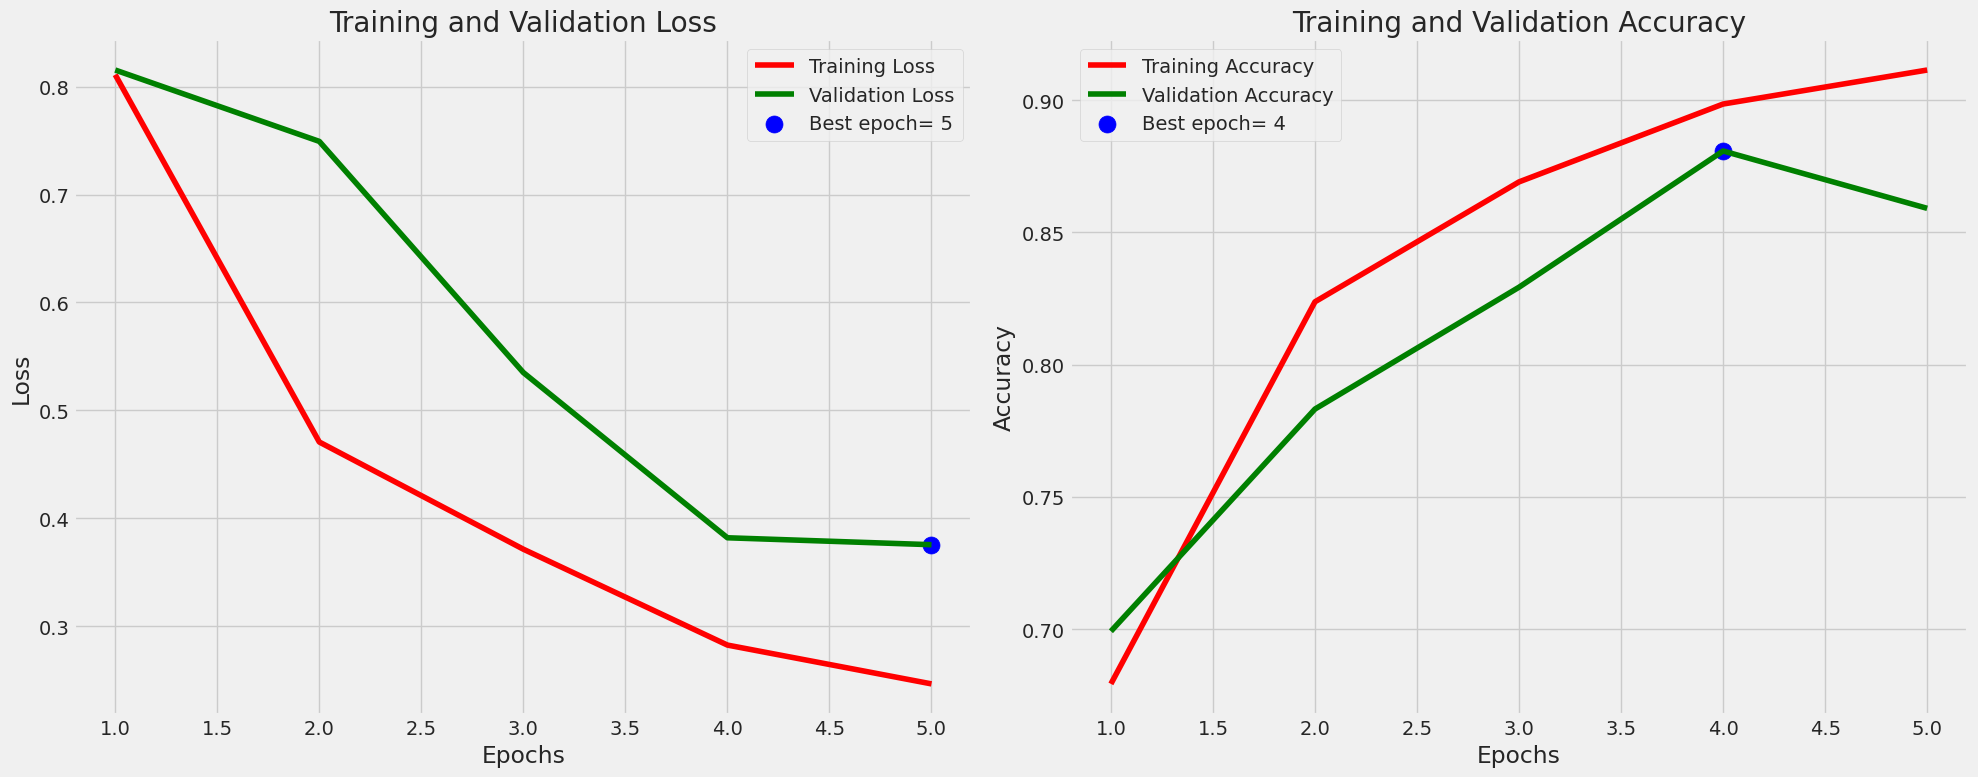

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.8509 - loss: 0.3512
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8717 - loss: 0.3163
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.8549 - loss: 0.5865
Train Loss:  0.317200243473053
Train Accuracy:  0.862500011920929
--------------------
Valid Loss:  0.31080162525177
Valid Accuracy:  0.862500011920929
--------------------
Test Loss:  0.5437471270561218
Test Accuracy:  0.856249988079071


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define the ResNet101 base model
base_model_resnet101 = ResNet101(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

def build_resnet101_model():
    x = base_model_resnet101.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(5, activation='softmax')(x)

    model_resnet101 = Model(inputs=base_model_resnet101.input, outputs=output)
    model_resnet101.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])
    return model_resnet101

def train_and_evaluate_resnet101(train_gen, valid_gen):
    print("Training ResNet101...")
    
    model_resnet101 = build_resnet101_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('resnet101_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_resnet101 = model_resnet101.fit(
        train_gen,
        epochs=5,
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    # Evaluate the model
    val_loss, val_accuracy = model_resnet101.evaluate(valid_gen)
    print(f"ResNet101 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model_resnet101.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)
    val_true_labels = valid_gen.classes

    # Classification Report
    print(f"ResNet101 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

    return model_resnet101, history_resnet101  

model_resnet101, history_resnet101 = train_and_evaluate_resnet101(train_gen, valid_gen)

# Plotting training and validation metrics
tr_acc = history_resnet101.history['accuracy']
tr_loss = history_resnet101.history['loss']
val_acc = history_resnet101.history['val_accuracy']
val_loss = history_resnet101.history['val_loss']

# Find best epochs
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch= {str(index_loss + 1)}'
acc_label = f'Best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_validation_plots.png')
plt.show()

# Evaluate on training, validation, and test datasets
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model_resnet101.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model_resnet101.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model_resnet101.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


In [42]:
model_resnet101.save('resnet101_final_model.h5')  


Training ResNet101...
Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.7672 - loss: 0.5928
Epoch 1: val_loss improved from inf to 0.55663, saving model to resnet101_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 138s 576ms/step - accuracy: 0.7681 - loss: 0.5909 - val_accuracy: 0.8022 - val_loss: 0.5566 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9014 - loss: 0.2854
Epoch 2: val_loss improved from 0.55663 to 0.54130, saving model to resnet101_best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.9015 - loss: 0.2853 - val_accuracy: 0.8157 - val_loss: 0.5413 - learning_rate: 1.0000e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9124 - loss: 0.2360
Epoch 3: val_loss did not improve from 0.54130
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.9123 - loss: 0.2363 - val_accuracy: 0.8103 - val_loss: 3.4529 - learning_rate: 1.0000e-04
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step 

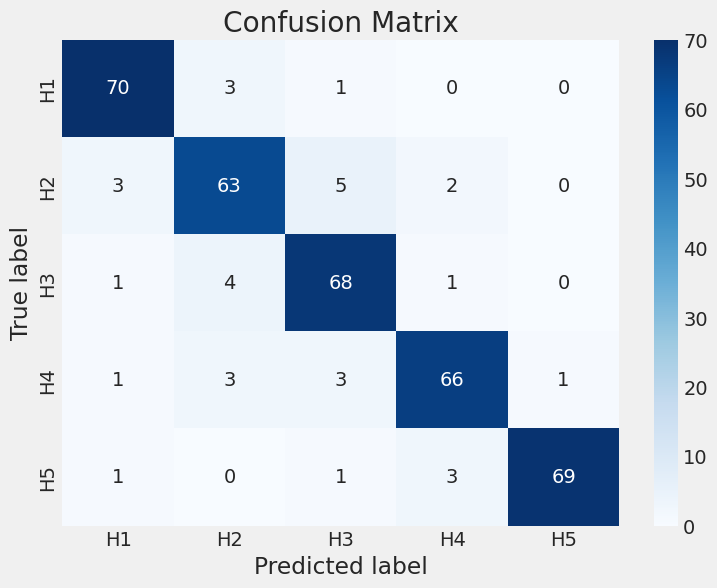

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

def train_and_evaluate_resnet101(train_gen, valid_gen):
    print("Training ResNet101...")
    
    model_resnet101 = build_resnet101_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('resnet101_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_resnet101 = model_resnet101.fit(
        train_gen,
        epochs=5,
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    # Evaluate the model
    val_loss, val_accuracy = model_resnet101.evaluate(valid_gen)
    print(f"ResNet101 Validation Accuracy: {val_accuracy:.4f}")

    # Predictions
    val_predictions = model_resnet101.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)
    val_true_labels = valid_gen.classes

    # Classification Report
    print(f"ResNet101 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

    # Confusion Matrix
    conf_matrix = confusion_matrix(val_true_labels, val_predictions_classes)
    plt.figure(figsize=(8, 6))
    plt.title("Confusion Matrix")
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=valid_gen.class_indices.keys(), yticklabels=valid_gen.class_indices.keys())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

train_and_evaluate_resnet101(train_gen, valid_gen)


# LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

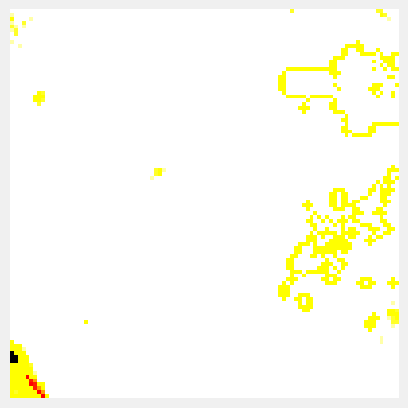

In [48]:
import lime
import lime.lime_image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.segmentation import mark_boundaries
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np

model = load_model('/kaggle/working/resnet101_final_model.h5')

explainer = lime.lime_image.LimeImageExplainer()

img_path = '/kaggle/input/de-fungi/de_fungi/H1/H1_10a_2.jpg'
img = Image.open(img_path).resize((100, 100))
img = np.array(img)

if len(img.shape) == 2:
    img = np.stack((img,)*3, axis=-1)

img = preprocess_input(img)

def predict_fn(images):
    processed_images = np.array([preprocess_input(image) for image in images])
    return model.predict(processed_images)

explanation = explainer.explain_instance(img, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.savefig("Cyst.png", dpi=300, bbox_inches='tight')

plt.show()

# SHAP

  0%|          | 0/7998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [03:54, 234.99s/it]              


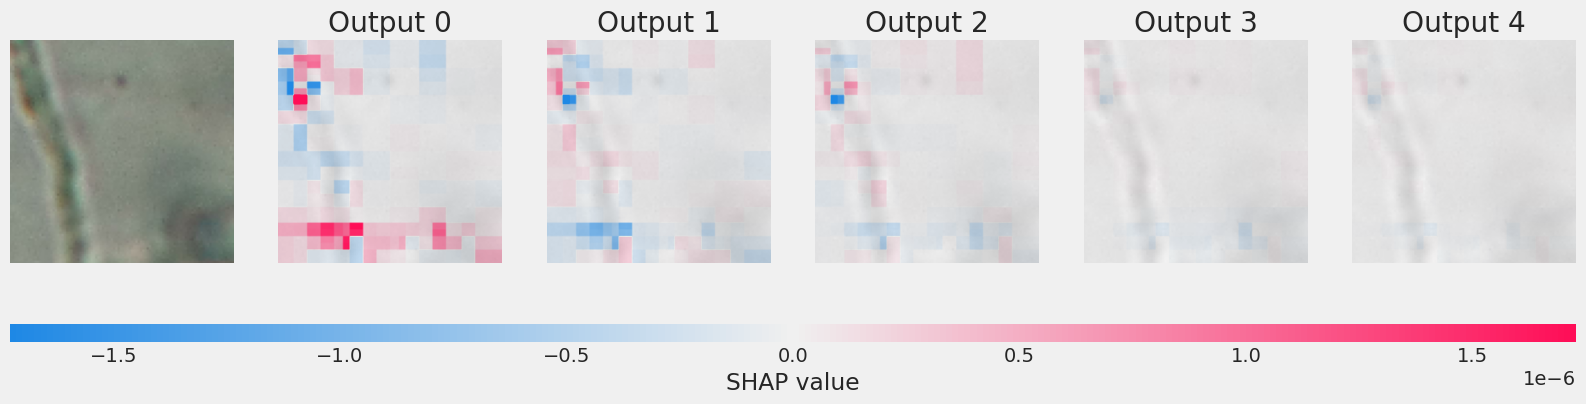

In [50]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model

dataset_dir = "/kaggle/input/de-fungi/de_fungi/H1"

image_path = "/kaggle/input/de-fungi/de_fungi/H1/H1_10a_5.jpg"

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [100, 100])  
    image = tf.cast(image, tf.float32) / 255.0   
    return image.numpy()

image = preprocess_image(image_path)

model = load_model('/kaggle/working/resnet101_final_model.h5')

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(100,100)", shape=(100, 100, 3))

explainer_blur = shap.Explainer(f, masker_blur)

shap_values_fine = explainer_blur(image[np.newaxis, :, :, :], max_evals=8000, outputs=shap.Explanation.argsort.flip[:8])

shap.image_plot(shap_values_fine)

#fig = plt.figure(figsize=(10, 10))
#shap.image_plot(shap_values_fine, show=False)
fig.savefig("shap_cyst.png", dpi=300, bbox_inches='tight')
plt.show()

# GRAD_CAM

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


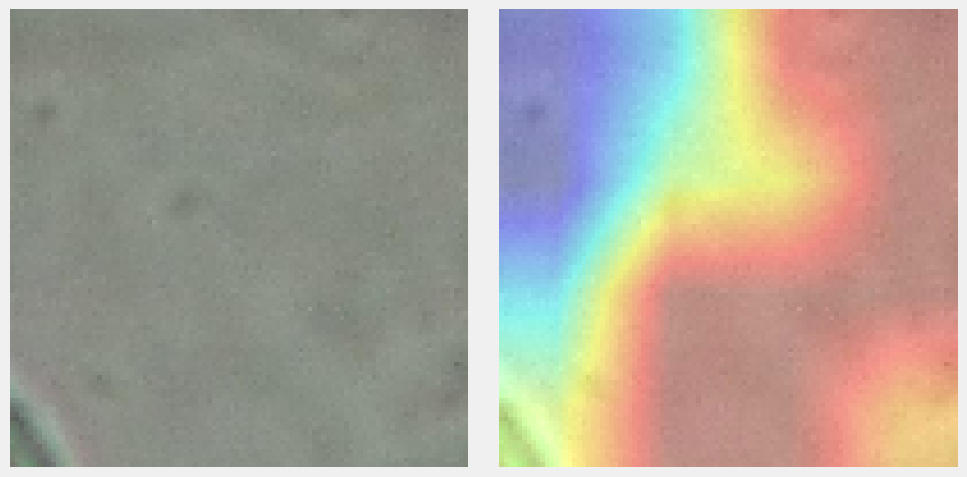

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

model = load_model('/kaggle/working/resnet101_final_model.h5')

img_path = '/kaggle/input/de-fungi/de_fungi/H1/H1_10a_2.jpg'
img = load_img(img_path, target_size=(100, 100))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
class_idx = np.argmax(preds[0])

last_conv_layer = model.get_layer('conv5_block3_out')
grad_model = Model(model.inputs, [last_conv_layer.output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, class_idx]

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + np.array(img)
superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.axis('off')

plt.tight_layout()
plt.savefig("gradcam_result.png", dpi=300, bbox_inches='tight')
plt.show()

# GRAD-CAM++

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


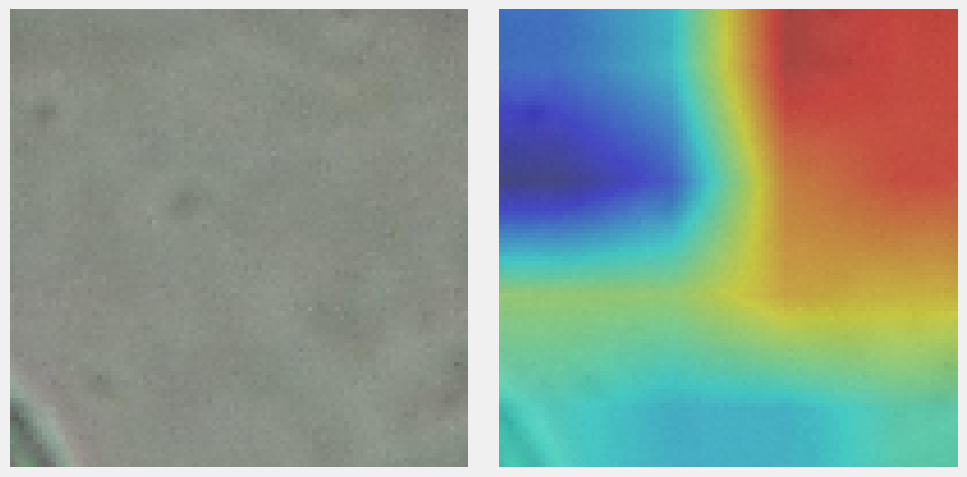

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model

model = load_model('/kaggle/working/resnet101_final_model.h5')

img_path = '/kaggle/input/de-fungi/de_fungi/H1/H1_10a_2.jpg'
img = load_img(img_path, target_size=(100, 100))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
class_idx = np.argmax(preds[0])

last_conv_layer = model.get_layer('conv5_block3_out')
grad_model = Model(model.inputs, [last_conv_layer.output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, class_idx]
    
grads = tape.gradient(loss, conv_outputs)[0]
conv_outputs = conv_outputs[0]

first_derivative = tf.exp(loss)[0] * grads
second_derivative = first_derivative * grads
third_derivative = second_derivative * grads

global_sum = tf.reduce_sum(conv_outputs, axis=(0, 1))

alpha_num = second_derivative
alpha_denom = second_derivative * 2.0 + third_derivative * global_sum
alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))
alphas = alpha_num / alpha_denom

weights = tf.reduce_sum(alphas * tf.nn.relu(first_derivative), axis=(0, 1))
heatmap = tf.reduce_sum(weights * conv_outputs, axis=-1)

heatmap = tf.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)
heatmap = heatmap.numpy()

heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(np.array(img), 0.5, heatmap, 0.5, 0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.axis('off')

plt.tight_layout()
plt.savefig("gradcam_plus_plus_result.png", dpi=300, bbox_inches='tight')
plt.show()

# Saliency Maps

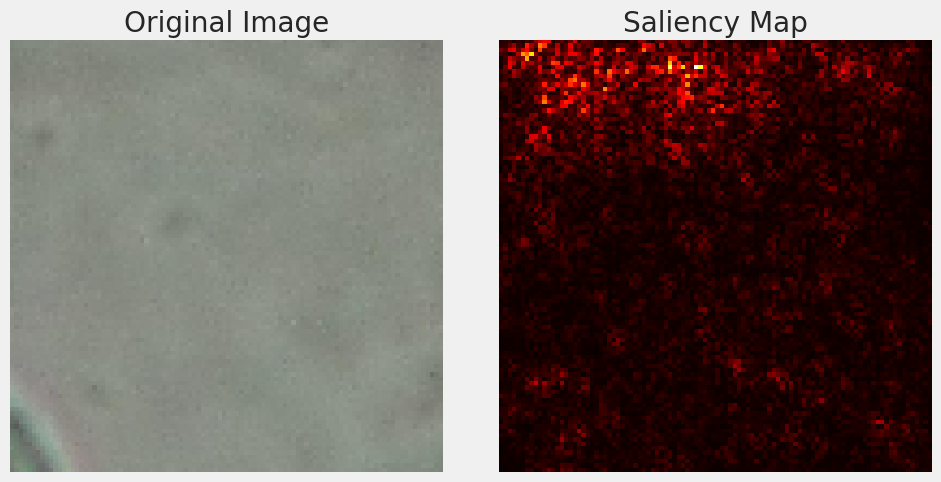

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

model = load_model('/kaggle/working/resnet101_final_model.h5')
img_path = '/kaggle/input/de-fungi/de_fungi/H1/H1_10a_2.jpg'
img = load_img(img_path, target_size=(100, 100))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

x_tensor = tf.convert_to_tensor(x)

with tf.GradientTape() as tape:
    tape.watch(x_tensor)
    predictions = model(x_tensor)
    class_idx = tf.argmax(predictions[0])
    loss = predictions[:, class_idx]

grads = tape.gradient(loss, x_tensor)[0]

saliency = tf.reduce_max(tf.abs(grads), axis=-1)

saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency, cmap='hot')
plt.title('Saliency Map')
plt.axis('off')

plt.tight_layout()
plt.savefig("saliency_map.png", dpi=300, bbox_inches='tight')
plt.show()

#  Integrated Gradients

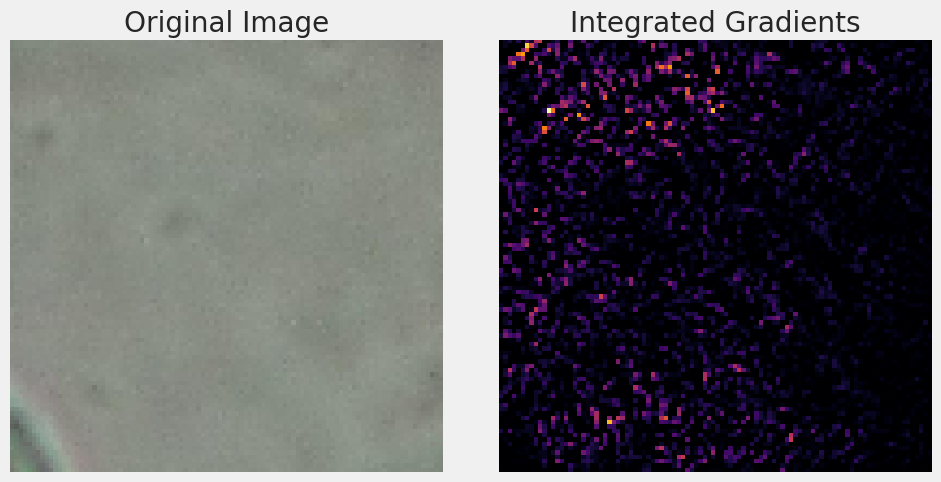

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

model = load_model('/kaggle/working/resnet101_final_model.h5')
img_path = '/kaggle/input/de-fungi/de_fungi/H1/H1_10a_2.jpg'
img = load_img(img_path, target_size=(100, 100))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

baseline = np.zeros_like(x)

steps = 50

alphas = tf.linspace(0.0, 1.0, steps)

gradients = []
for alpha in alphas:
    interpolated = baseline + alpha * (x - baseline)
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = model(interpolated)
        top_class = preds[:, tf.argmax(preds[0])]
    grad = tape.gradient(top_class, interpolated)
    gradients.append(grad[0])

gradients = tf.stack(gradients)
avg_gradients = tf.reduce_mean(gradients, axis=0)

integrated_gradients = (x - baseline) * avg_gradients

ig = tf.reduce_sum(integrated_gradients, axis=-1)[0]
ig = tf.maximum(ig, 0)  
ig /= tf.reduce_max(ig)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ig, cmap='inferno')
plt.title('Integrated Gradients')
plt.axis('off')

plt.tight_layout()
plt.savefig("integrated_gradients.png", dpi=300, bbox_inches='tight')
plt.show()

# Activation Maximization

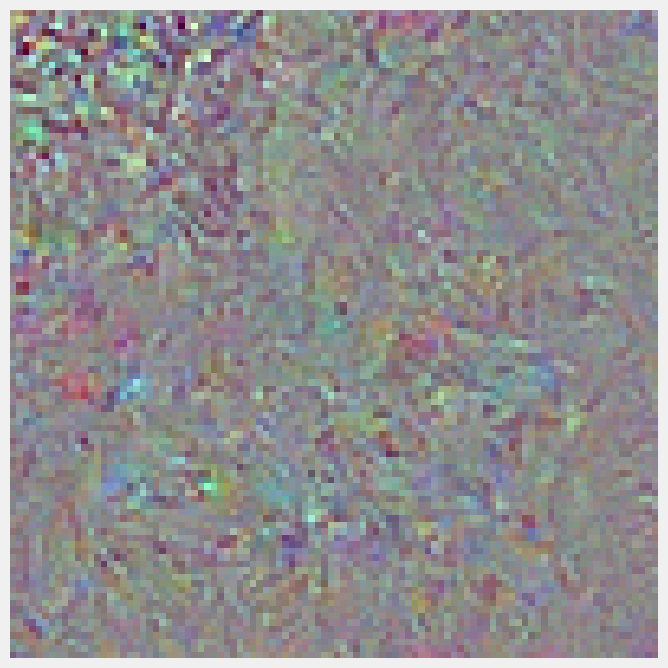

In [69]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

model = load_model('/kaggle/working/resnet101_final_model.h5')

target_class = 0  # Change to your target class index
input_shape = (100, 100, 3)
steps = 200
learning_rate = 10.0

def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

input_img = np.random.random((1,) + input_shape) * 20 + 128.0
input_img = tf.Variable(input_img, dtype=tf.float32)

for i in range(steps):
    with tf.GradientTape() as tape:
        tape.watch(input_img)
        preds = model(input_img)
        loss = -preds[0, target_class]
    grads = tape.gradient(loss, input_img)
    grads = normalize(grads)
    input_img.assign_add(grads * learning_rate)
    input_img.assign(tf.clip_by_value(input_img, 0, 255))

dream = input_img.numpy()[0]
dream = np.clip(dream, 0, 255).astype('uint8')

plt.figure(figsize=(8, 8))
plt.imshow(dream)
plt.axis('off')
plt.savefig("activation_maximization.png", dpi=300, bbox_inches='tight')
plt.show()

# SmoothGrad

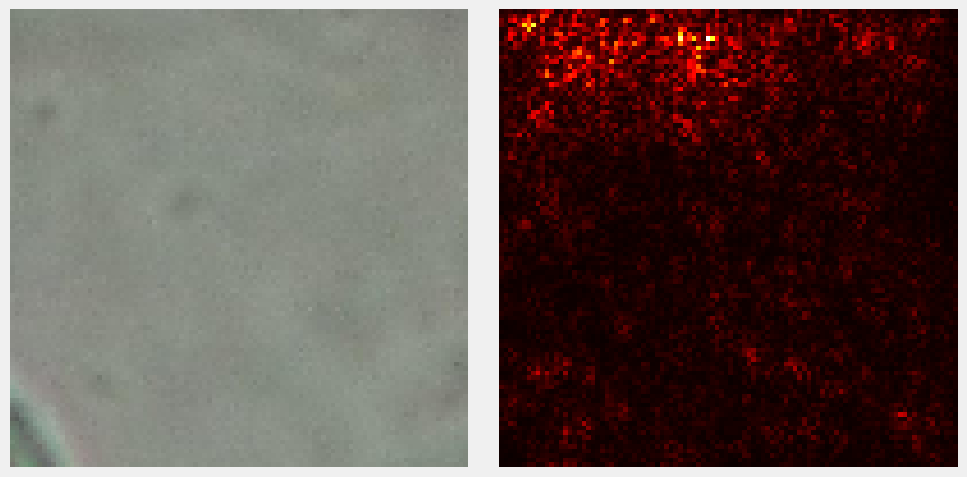

In [80]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

model = load_model('/kaggle/working/resnet101_final_model.h5')

img_path = '/kaggle/input/de-fungi/de_fungi/H1/H1_10a_2.jpg'
img = load_img(img_path, target_size=(100, 100))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

x_tensor = tf.convert_to_tensor(x)
noise_std = 0.1
num_samples = 50

gradients = []
for _ in range(num_samples):
    noise = tf.random.normal(shape=x.shape, mean=0.0, stddev=noise_std)
    noisy_input = x_tensor + noise
    with tf.GradientTape() as tape:
        tape.watch(noisy_input)
        preds = model(noisy_input)
        top_class = preds[:, tf.argmax(preds[0])]
    grad = tape.gradient(top_class, noisy_input)
    gradients.append(grad[0])

avg_gradients = tf.reduce_mean(gradients, axis=0)
saliency = tf.reduce_max(tf.abs(avg_gradients), axis=-1)
saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency, cmap='hot')
plt.axis('off')

plt.tight_layout()
plt.savefig("smoothgrad.png", dpi=300, bbox_inches='tight')
plt.show()